# 🍳 Data Preparation

<img src="https://i.imgur.com/kfXArBp.png">

### 📊 Scikit-learn Datasets Module

Read more about the `sklearn.datasets` module over [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets). This module isn't at the core of Scikit learn's commonly used functionality. It mainly allows us to do two things:
- Load existing known datasets for experimentation
- Generate custom datasets for experimentation

#### 1. Loading Datasets

In [2]:
import numpy as np
from sklearn import datasets

digits_data = datasets.load_digits()            # returns an object of type Bunch with data and target attributes
x_data, y_data = digits_data.data, digits_data.target

print("x_data and y_data shapes:", x_data.shape, y_data.shape)
print("unique labels:", np.unique(y_data))

x_data and y_data shapes: (1797, 64) (1797,)
unique labels: [0 1 2 3 4 5 6 7 8 9]


Scikit learn has many internal datasets like digits. They also have the function `fetch_openml` which is more generic and can load any [OpenML](https://www.openml.org/search?type=data) dataset

In [3]:
from sklearn import datasets

x_data, y_data = datasets.fetch_openml(name='iris', parser='auto', return_X_y=True)

print("x_data and y_data shapes:", x_data.shape, y_data.shape)
print("unique labels:", np.unique(y_data))

x_data and y_data shapes: (150, 4) (150,)
unique labels: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


/opt/anaconda3/envs/M1/lib/python3.9/site-packages/sklearn/datasets/_openml.py:322: UserWarning: Multiple active versions of the dataset matching the name iris exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=61
- version 3, status: active
  url: https://www.openml.org/search?type=data&id=969

  warn(warning_msg)


#### 2. Generating Datasets

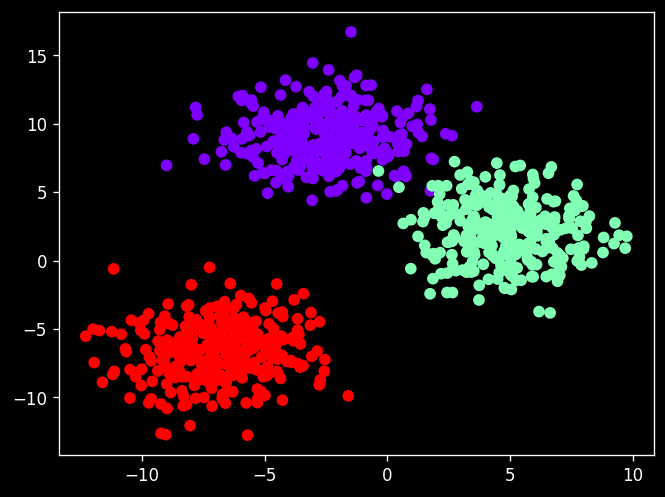

In [3]:
from sklearn import datasets
import matplotlib.pyplot as plt

X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, centers=3, cluster_std=2.0, random_state=42)

# plot the data
plt.style.use('dark_background'); plt.figure(dpi=120)
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs, cmap='rainbow')
plt.show()

There is also `make_classification`, `datasets.make_circles`, `make_moons`, etc.

### 🔍 Scikit-learn Imputation Module

Offers mainly `SimpleImputer`, `KNNImputer` and `MultivariateImputer`.

KNNImputer imputes the missing values based on voting over the nearest neighbors. The missing value doesn't take part in the Euclidean distance computation.

In [4]:
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer

x_data = np.array([[1, 2, np.nan], 
                    [3, 4, 3], 
                    [np.nan, 6, 5], 
                    [8, 8, 7]])

In [5]:
imputer = KNNImputer(missing_values=np.nan, n_neighbors=1)
imputer.fit_transform(x_data)

array([[1., 2., 3.],
       [3., 4., 3.],
       [3., 6., 5.],
       [8., 8., 7.]])

In [6]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit_transform(x_data)

array([[1., 2., 5.],
       [3., 4., 3.],
       [4., 6., 5.],
       [8., 8., 7.]])

#### Another common task in data cleaning involves addressing outliers.

- Scikit learn has no formal module for it since outlier detection (i.e., anomaly detection) is a subset of unsupervised machine learning algorithms
- Pandas users use more classical techniques (e.g., compute z-score or IQR and jude based on that)

In [7]:
import numpy as np
from sklearn.neighbors import LocalOutlierFactor

X = [[-1.1], [0.2], [101.1], [0.3]]
clf = LocalOutlierFactor(n_neighbors=2, algorithm='ball_tree')      
# Measures the local deviation of the density of a given sample with respect to its neighbors
clf.fit_predict(X)
clf.negative_outlier_factor_

array([ -0.98214286,  -1.03703704, -73.36970899,  -0.98214286])

### 📦 Preprocessing

The [sklearn.preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) module offers many preprocessing functions for machine learning. The two most important categories of preprocessing considered in this case are:

1. Scaling techniques for numerical features
<br><br>
2. Encoding techniques for categorical features

#### Scaling Numerical Features

`MinMaxScaler` scales and translates each feature individually such that it is in the given range on the training set, e.g. between $0$ and $1$.

$$ X_{\text{new}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}} $$

In [8]:
from sklearn.preprocessing import MinMaxScaler

x_train = [[-1, 200], 
          [-0.5, 60], 
          [0, 100], 
          [1, 180]]
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(x_train)

x_data_norm = scaler.transform(x_train)
print("Model will be trained on the following scaled data:\n", x_data_norm, end="\n\n")
print("Thus, we need to transform points in test time as well:", scaler.transform([[2, 2]]))

Model will be trained on the following scaled data:
 [[0.         1.        ]
 [0.25       0.        ]
 [0.5        0.28571429]
 [1.         0.85714286]]

Thus, we need to transform points in test time as well: [[ 1.5        -0.41428571]]


On the other hand, we also have `StandardScaler()` which computes $μ$ and $σ$ for each feature to apply:
$$X_{new} = \frac {X-μ}{σ}$$
This is called standardization. Some machine learning models assume standardized input data as this simplifies the computation. It's also more robust than min-max scaling if outliers exist:

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_scaling_importance_001.png)

#### Encoding Categorical Features

As we all know, the vast majority of machine learning models operate on `(m, n)` matrix input of numerical data for training and `(n,)` numerical vectors at inference. 
- The exception to this are tree methods as will be seen later.

In [9]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, TargetEncoder      
from sklearn.model_selection import train_test_split

# Create some toy data
data = {
    "customer_id": [1, 2, 3, 4, 5],
    "country": ["US", "Canada", "Mexico", "Canada", "US"],
    "product": ["A", "B", "A", "C", "B"],
    "service_level": ["Gold", "Silver", "Gold", "Bronze", "Silver"],
    "high_revenue": [1, 0, 1, 0, 1]
}

df = pd.DataFrame(data)

# Separate categorical features
categorical_features = ["country", "product", "service_level"]
df

,customer_id,country,product,service_level,high_revenue
0,1,US,A,Gold,1
1,2,Canada,B,Silver,0
2,3,Mexico,A,Gold,1
3,4,Canada,C,Bronze,0
4,5,US,B,Silver,1


#### Ordinal Encoder

The most basic approach is `OrdinalEncoder` which simply maps the categories to ordered integers

In [10]:
ordinal_encoder = OrdinalEncoder()
df_ordinal = df.copy()
df_ordinal[categorical_features] = ordinal_encoder.fit_transform(df[categorical_features])
# will need to transform test points later!
df_ordinal

,customer_id,country,product,service_level,high_revenue
0,1,2.0,0.0,1.0,1
1,2,0.0,1.0,2.0,0
2,3,1.0,0.0,1.0,1
3,4,0.0,2.0,0.0,0
4,5,2.0,1.0,2.0,1


Note that Scikit learn also has `LabelEncoder` which does the same thing but for one column (the target variable).

The problem with this approach is that it introduces inexistent relationships between categories of the same variable. Each ordering also will yield a dataset that looks different in the feature space. It should be only used when there is a true ordinal relationship for the categorical variable (e.g., cold, mild, hot)

#### One-Hot Encoder

Many machine learning models don't mind dealing with binary variables or at least are less affected by them compared to fake ordinal ones. In this case, we convert a categorical column $x$ that takes possible values $A$, $B$, $C$ into three binary columns `x_is_A`, `x_is_B`, `x_is_C`. This is called `OneHotEncoding` 

- Such models can often interpret 0 as being the feature does not apply and 1 as the feature applies


In [11]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
df_onehot_np = one_hot_encoder.fit_transform(df[categorical_features])
df_onehot_np
# TODO: Check how to do this column by column using pd.get_dummies

array([[0., 0., 1., 1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0., 1.]])

The problem with this approach is that it highly inflates the dimensionality of the feature space and makes the dataset sparse. The problem is aggrevated when high cardinality features (e.g., location) are present.

#### Target Encoding

A known approach to the encoding problem and is usually perceived as the most successful. 

- In regression settings, to encode category $c_i$ for categorical column $c$, replace it with the average of the target variable $y$ given that $c=c_i$. 

**Why does it work?**
- If the average value of $y$ does not vary from one category to another then the feature isn't really that distinctive of the target and the target encoded feature won't be that useful. 

- On the other hand, the average of the target could strongly vary based on the categorical value in which case the replacement we did corresponds to a distinctive feature for the model (e.g., grade based on `studied`, `slept`, `studied while slept`).
    - When the `grade=slept` the model will receive 15 (average grade of slept students) and it can more easily perform the regression (learn the mapping) because the actual will be not far from that number and other features can help with that.

In case of binary classification:
- Use the frequency of the positive class instead of the average



Check out the multiclass case with $K$ classes and we can discuss it if interested.

In [21]:
target_encoder = TargetEncoder()
x_train = df[categorical_features]
y_train = df["high_revenue"]
target_encoder.fit(x_train, y_train)
df_targetencoded = df.copy()
df_targetencoded[categorical_features] = target_encoder.transform(df[categorical_features])

print("\nTarget Encoded Data:")
print(df_targetencoded.head())


Target Encoded Data:
   customer_id  country   product  service_level  high_revenue
0            1      1.0  1.000000       1.000000             1
1            2      0.0  0.534247       0.534247             0
2            3      1.0  1.000000       1.000000             1
3            4      0.0  0.000000       0.000000             0
4            5      1.0  0.534247       0.534247             1


**[Optional TODO]: Compare these three encoding methods using the Mushroom dataset from Kaggle and your favorite machine learning model.**